[*********************100%%**********************]  1 of 1 completed
3493/3493 - 18s - loss: 0.0012 - val_loss: 0.0042 - 18s/epoch - 5ms/step
3493/3493 - 18s - loss: 9.3412e-04 - val_loss: 0.0018 - 18s/epoch - 5ms/step
Epoch 1/50, LSTM Loss: 0.0011679909657686949, GRU Loss: 0.0009341157274320722, Time: 44.17922568321228
3493/3493 - 15s - loss: 1.5747e-04 - val_loss: 0.0059 - 15s/epoch - 4ms/step
3493/3493 - 16s - loss: 1.0526e-04 - val_loss: 0.0012 - 16s/epoch - 5ms/step
Epoch 2/50, LSTM Loss: 0.0001574700145283714, GRU Loss: 0.00010526324331294745, Time: 75.3254463672638
3493/3493 - 16s - loss: 1.2294e-04 - val_loss: 0.0019 - 16s/epoch - 5ms/step
3493/3493 - 17s - loss: 8.1131e-05 - val_loss: 0.0011 - 17s/epoch - 5ms/step
Epoch 3/50, LSTM Loss: 0.00012293909094296396, GRU Loss: 8.11307254480198e-05, Time: 113.24223613739014
3493/3493 - 17s - loss: 1.0435e-04 - val_loss: 0.0012 - 17s/epoch - 5ms/step
3493/3493 - 17s - loss: 7.4407e-05 - val_loss: 9.7879e-04 - 17s/epoch - 5ms/step
Epoch

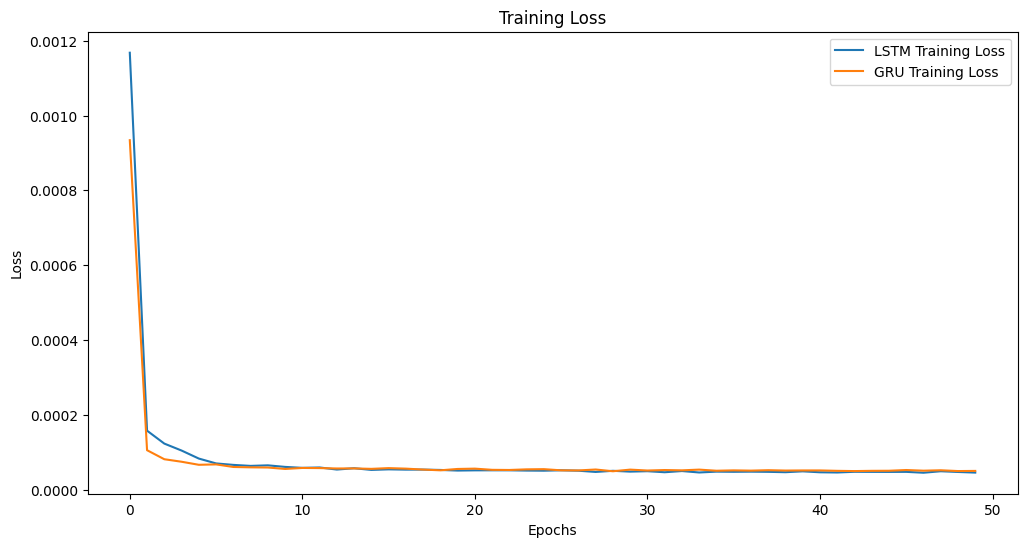

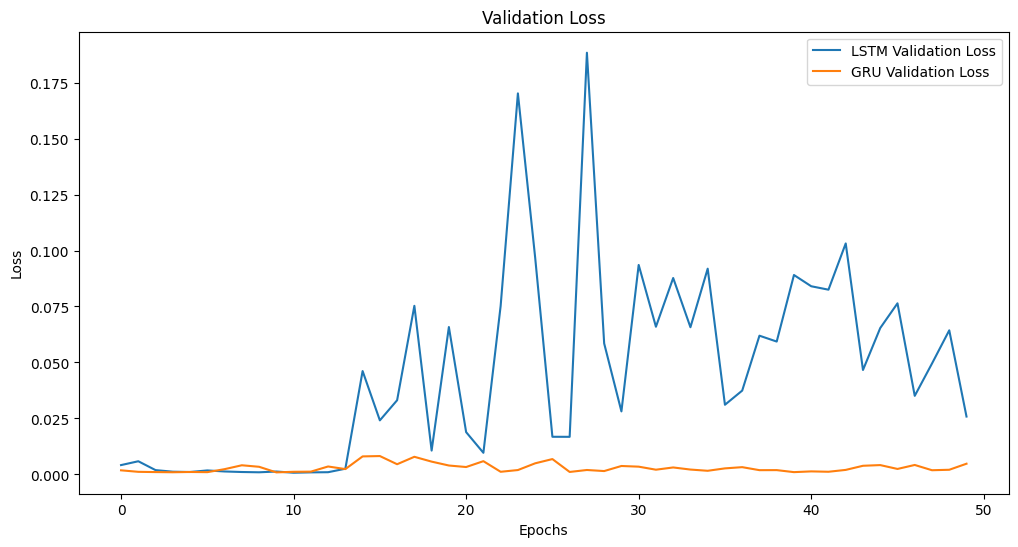

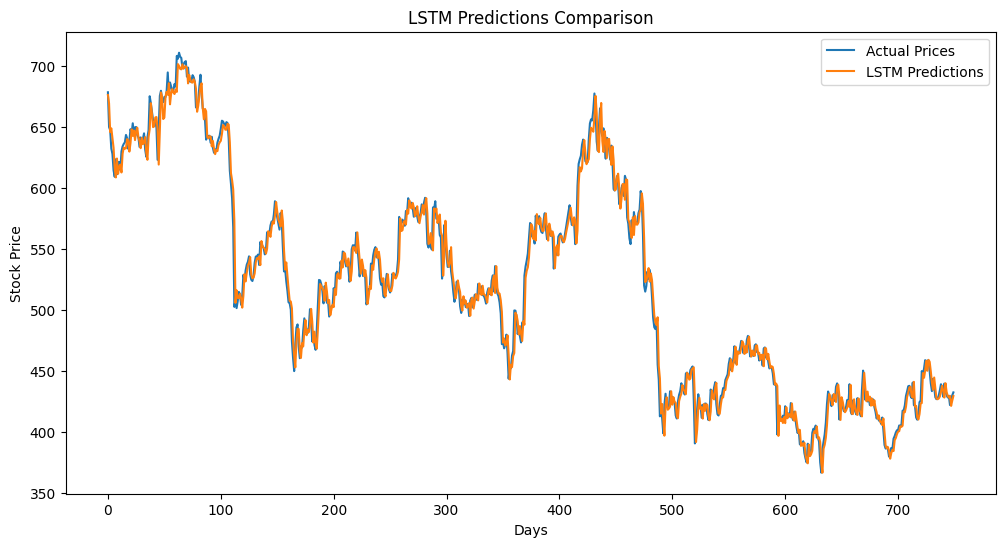

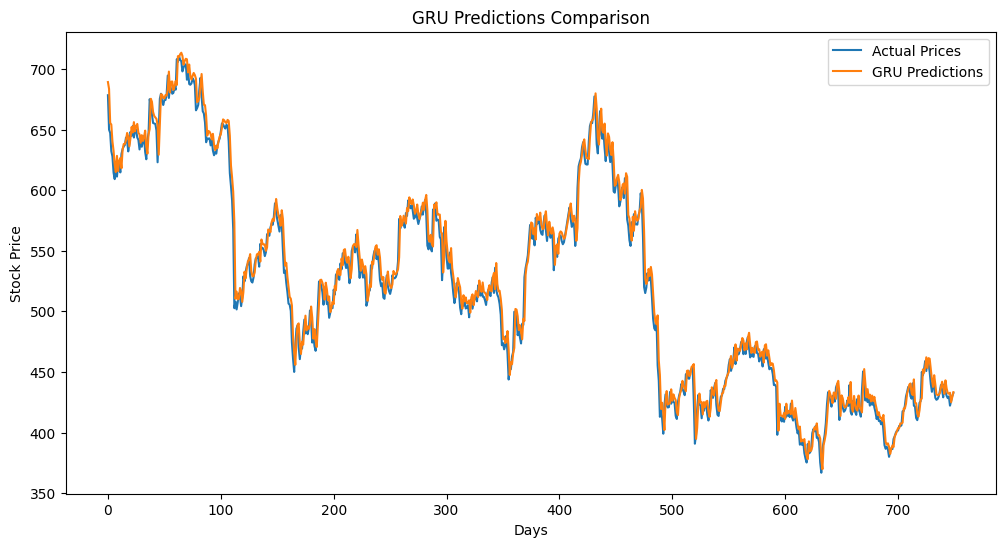

LSTM MAE: 7.9978, GRU MAE: 8.5034
LSTM MAPE: 0.0156, GRU MAPE: 0.0166
LSTM RMSE: 10.8179, GRU RMSE: 11.3661


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import matplotlib.pyplot as plt
import time

# Download Sun Pharmaceutical Industries Limited (SUNPHARMA.NS) data from Yahoo Finance
start_date = '2000-01-01'
end_date = '2020-01-01'
sunpharma_data = yf.download('SUNPHARMA.NS', start=start_date, end=end_date)

# Remove null values
sunpharma_data = sunpharma_data.dropna()

# Preprocess the data
scaler = MinMaxScaler(feature_range=(-1, 1))
sunpharma_data['Scaled Close'] = scaler.fit_transform(sunpharma_data['Close'].values.reshape(-1, 1))

# Function to create sequences from time series data
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data[i+sequence_length])
    return np.array(sequences), np.array(targets)

# Create sequences and targets
sequence_length = 10
X, y = create_sequences(sunpharma_data['Scaled Close'].values, sequence_length)

# Split the data into train, validation, and test sets
train_size = int(len(X) * 0.70)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[-test_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[-test_size:]

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='tanh', input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dense(units=1, activation='linear'))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Build GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, activation='tanh', input_shape=(X_train.shape[1], 1)))
model_gru.add(Dense(units=1, activation='linear'))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Training and validation
epochs = 50
start_time = time.time()

# Lists to store metrics for plotting
lstm_train_loss, gru_train_loss = [], []
lstm_val_loss, gru_val_loss = [], []

for epoch in range(epochs):
    # Train LSTM
    lstm_history = model_lstm.fit(X_train, y_train, epochs=1, batch_size=1, validation_data=(X_val, y_val), verbose=2)

    lstm_train_loss.append(lstm_history.history['loss'][0])
    lstm_val_loss.append(lstm_history.history['val_loss'][0])

    # Train GRU
    gru_history = model_gru.fit(X_train, y_train, epochs=1, batch_size=1, validation_data=(X_val, y_val), verbose=2)

    gru_train_loss.append(gru_history.history['loss'][0])
    gru_val_loss.append(gru_history.history['val_loss'][0])

    # Display results
    print(f"Epoch {epoch+1}/{epochs}, LSTM Loss: {lstm_train_loss[-1]}, GRU Loss: {gru_train_loss[-1]}, Time: {time.time() - start_time}")

# Evaluate models on the test set
lstm_predictions = model_lstm.predict(X_test)
gru_predictions = model_gru.predict(X_test)

# Invert scaling to get predicted stock prices
lstm_predictions = scaler.inverse_transform(lstm_predictions)
gru_predictions = scaler.inverse_transform(gru_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
gru_mae = mean_absolute_error(y_test, gru_predictions)

lstm_mape = mean_absolute_percentage_error(y_test, lstm_predictions)
gru_mape = mean_absolute_percentage_error(y_test, gru_predictions)

lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_predictions))

# Figure 1: Training Loss
plt.figure(figsize=(12, 6))
plt.plot(lstm_train_loss, label='LSTM Training Loss')
plt.plot(gru_train_loss, label='GRU Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Figure 2: Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(lstm_val_loss, label='LSTM Validation Loss')
plt.plot(gru_val_loss, label='GRU Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Figure 3: LSTM Predictions Comparison
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Prices')
plt.plot(lstm_predictions, label=f'LSTM Predictions')
plt.title('LSTM Predictions Comparison')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Figure 4: GRU Predictions Comparison
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Prices')
plt.plot(gru_predictions, label=f'GRU Predictions')
plt.title('GRU Predictions Comparison')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Display calculated metrics
print(f"LSTM MAE: {lstm_mae:.4f}, GRU MAE: {gru_mae:.4f}")
print(f"LSTM MAPE: {lstm_mape:.4f}, GRU MAPE: {gru_mape:.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}, GRU RMSE: {gru_rmse:.4f}")
